In [2]:
import json
from Levenshtein import distance as word_difference
from gensim.utils import simple_preprocess
import re
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
SERVICE_REQ_JSON_FILE_NAME = 'service_requests_last_90_days.json'

In [4]:
def extract_request_id_with_description(filename:str) -> dict:
    ''' 
    For a given file containing a JSON Array of Service Request JSON Objects, extract the service number and the description
    (if it exists) into a dictionary for further preprocessing.

    Returns: Dict (Service Request ID -> Service Request Description)
    '''
    request_id_descr_dict = {}
    service_requests_json = json.loads(open(filename, 'r').read())

    for service_request in service_requests_json:
        # Ensure the description exists for this service request
        description = service_request.get('description', False)
        if not description: continue   
        # status_notes = service_request.get('status_notes', False)
        # if status_notes:
        #     description = description + ' | ' + status_notes

        # Add to dictionary using service request ID as key and service request description as value.
        request_id_descr_dict[service_request['service_request_id']] = description

    return request_id_descr_dict

In [5]:
document_dictionary = extract_request_id_with_description(SERVICE_REQ_JSON_FILE_NAME)

In [6]:
len(document_dictionary.keys())

9638

In [7]:
class_keywords = {

    'blocked bike infra': ['bike'],
    'blocked public transit infra': ['bus'],
    'blocked emergency infra':  ['hydrant'],
    'resident parking': ['resident', 'nonresident', 'sticker'],
    'blocked driveway': ['driveway'],
    'blocked pedestrian infra':  ['crosswalk', 'sidewalk'],
    'blocked accesibility infra': ['handicap'],
    'traffic flow impediment': ['double', 'stopped']

}

Algo outline:

        for each class:
            find and catalog exact matches
    
        on remaining documents until none remain or distance max acheived:
            find and catalog matches with distance d
        
        if distance max acheived: remaining documents given unknown category


In [8]:
def categorize_illegal_parking_reports(descriptions:dict, class_keywords:dict, max_distance:int):

    match_count = 0

    # Tokenize descriptions
    description_tokens = {id: simple_preprocess(description, deacc=True) for id, description in descriptions.items()}

    # Create new dictionary to keep track of descriptions that are not yet categorized
    uncategorized_descriptions = dict(description_tokens)

    # Create dictionary for the list of service ids for each class
    class_service_ids = {}

    # Create dictionary to track classes assigned to service ids (to analyze prevalance of multiclass descriptions)
    service_id_classes = {}

    # Find exact matches
    uncategorized_descriptions_items = list(uncategorized_descriptions.items())
    for id, tokens in uncategorized_descriptions_items:
        match_found = False
        for category, keywords in class_keywords.items():
            if keywords_match(keywords, tokens):
                match_found = True
                match_count += 1

                # Track the match in both dicts
                service_ids:list = class_service_ids.get(category, [])
                service_ids.append(id)
                class_service_ids[category] = service_ids

                classes = service_id_classes.get(id, [])
                classes.append(category)
                service_id_classes[id] = classes
        
        # If any match was found remove it from the uncategorized dictionary
        if match_found: del uncategorized_descriptions[id]

    # find matches with increasing distance
    # create dictionary to hold fuzzy matches
    distance_matches = {}
    for distance in range(1, max_distance + 1):
        current_distance_matches = {}
        uncategorized_descriptions_items = list(uncategorized_descriptions.items())
        for id, tokens in uncategorized_descriptions_items:
            match_found = False
            for category, keywords in class_keywords.items():
                if keywords_fuzzy_match(keywords, tokens, distance):
                    match_found = True
                    match_count += 1

                    # Track the match in both dicts
                    service_ids = class_service_ids.get(category, [])
                    service_ids.append(id)
                    class_service_ids[category] = service_ids

                    classes = service_id_classes.get(id, [])
                    classes.append(category)
                    service_id_classes[id] = classes

                    distance_classes = current_distance_matches.get(category, [])
                    distance_classes.append(id)
                    current_distance_matches[category] = distance_classes

            
            # If any match was found remove it from the uncategorized dictionary
            if match_found: del uncategorized_descriptions[id]
        
        distance_matches[distance] = current_distance_matches
    
    # print(f'Found {match_count} matches!')
    return uncategorized_descriptions, class_service_ids, service_id_classes, distance_matches


def keywords_match(keywords:list[str], tokens:list[str]):
    affix_pattern = r'[a-z]*'
    for keyword in keywords:
        keyword_pattern = re.compile(affix_pattern + keyword + affix_pattern)
        all_tokens = str.join(' ', tokens)
        matches = re.findall(keyword_pattern, all_tokens)
        if matches:
            return True
        
    return False

def keywords_fuzzy_match(keywords:list[str], tokens:list[str], distance:int):
    for keyword in keywords:
        for token in tokens:
            difference = word_difference(keyword, token)
            if difference <= distance:
                return True
            
    return False

In [9]:
unknown_desc, class_service_ids, service_id_classes, distance_matches = categorize_illegal_parking_reports(document_dictionary, class_keywords, 1)

In [10]:
print(f'# Unk: {len(unknown_desc)}')
print(f'# Classified {sum([len(class_service_ids[cat]) for cat in class_service_ids.keys()])}')
print(f'# Distance Matches: {sum([len(distance_matches[dist][cat]) for dist in distance_matches.keys() for cat in distance_matches[dist].keys()])}')

# Unk: 3798
# Classified 6334
# Distance Matches: 89


Take the results of the categorization and process them into DataFrames for visualization

In [11]:
class_distr = {cat: len(ids) for cat, ids in class_service_ids.items()}
class_distr_df = pd.DataFrame(data=class_distr, index=['num_ids'])
class_distr_df.head()

,resident parking,blocked driveway,traffic flow impediment,blocked pedestrian infra,blocked accesibility infra,blocked emergency infra,blocked bike infra,blocked public transit infra
num_ids,2242,701,412,909,458,728,336,548


([<matplotlib.patches.Wedge at 0x134d9679300>,
 [Text(0.48714947484842686, 0.9862481377193583, 'resident parking'),
  Text(-0.9261557711984846, 0.5934943028165818, 'blocked driveway'),
  Text(-1.0998246535786254, 0.019640045332355756, 'traffic flow impediment'),
  Text(-0.8840459621272477, -0.654570650767745, 'blocked pedestrian infra'),
  Text(-0.27793207794006414, -1.0643090528845078, 'blocked accesibility infra'),
  Text(0.3593685318845668, -1.0396414085111902, 'blocked emergency infra'),
  Text(0.8340145830811341, -0.7172305593099071, 'blocked bike infra'),
  Text(1.059617602265326, -0.2953143020063219, 'blocked public transit infra')])

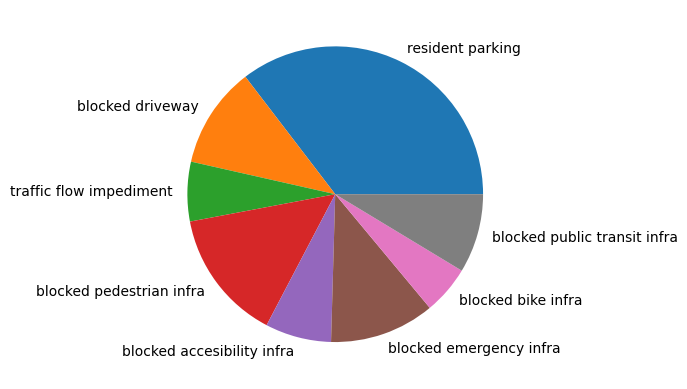

In [12]:
plt.clf()
plt.pie(x=class_distr.values(), labels=class_distr.keys())

## Packing up the classifications

Will be the same as the service request JSON objects, but will have an additional field 'CLASS' which is one of:
- resident parking
- blocked driveway
- blocked public transit infra
- traffic flow impediment
- blocked pedestrian infra
- blocked accesibility infra
- blocked emergency infra
- blocked bike infra
- unknown (uncategorized, contains no keywords within edit distance limit)

Additional field 'DIST' shows the edit distance of the service request. For example, a service request that contains a keyword with a single typo 
will have value 1. Two typos will have value 2.

In [29]:
# Load the json service requests into a dictionary with keys=id, values=json_obj
service_req_json = json.loads(open('service_requests_last_90_days.json', 'r').read())

service_req_json_dict = {obj['service_request_id']: obj for obj in service_req_json}

# go through each class, find each service id json object, add the proper fields, then save the json

classified_service_requests = []

# Distance zero requests
distance = 0
for class_name, ids in class_service_ids.items():
    for req_id in ids:
        req_json = service_req_json_dict[req_id]
        req_json['class'] = class_name
        req_json['distance'] = distance
        classified_service_requests.append(req_json)

# Distance requests
for dist, matches in distance_matches.items():
    distance = dist
    for class_name, ids in matches.items():
        for req_id in ids:
            req_json = service_req_json_dict[req_id]
            req_json['class'] = class_name
            req_json['distance'] = distance
            classified_service_requests.append(req_json)


with open('classified_requests_test1.json', 'w') as file:
    json.dump(classified_service_requests, file)
